<a href="https://colab.research.google.com/github/VoteSentry/finetune-ballot/blob/main/Pixtral_Vision_Finetuning_Unsloth_General_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://github.com/unslothai/unsloth?tab=readme-ov-file#-installation-instructions).

**[NEW] As of Novemeber 2024, Unsloth now supports vision finetuning!**

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)

**This notebook finetunes Pixtral 2409 (12B) for general question answering. We do some tweaks to make Pixtral fit in a Colab!**

In [1]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

* We support Llama 3.2 Vision 11B, 90B; Pixtral; Qwen2VL 2B, 7B, 72B; and any Llava variant like Llava NeXT!
* We support 16bit LoRA via `load_in_4bit=False` or 4bit QLoRA. Both are accelerated and use much less memory!

In [3]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Pixtral-12B-2409",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    # use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

==((====))==  Unsloth 2024.12.12: Fast Pixtral vision patching. Transformers: 4.47.1.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.0. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json:   0%|          | 0.00/214k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.22G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/133 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/162 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.59k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/177k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

**[NEW]** We also support finetuning ONLY the vision part of the model, or ONLY the language part. Or you can select both! You can also select to finetune the attention or the MLP layers!

In [4]:
model = FastVisionModel.get_peft_model(
    model,
    # We do NOT finetune vision & attention layers since Pixtral uses more memory!
    finetune_vision_layers     = False, # False if not finetuning vision layers
    finetune_language_layers   = True,  # False if not finetuning language layers
    finetune_attention_modules = False, # False if not finetuning attention layers
    finetune_mlp_modules       = True,  # False if not finetuning MLP layers

    r = 8,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 8,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

<a name="Data"></a>
### Data Prep
We'll be using a sampled dataset of general question and answering pairs. These datasets should be mixed with other finetunes to not make the model forget general tasks.

You can access the dataset [here](https://huggingface.co/datasets/unsloth/llava-instruct-mix-vsft-mini). The full dataset is [here](https://huggingface.co/datasets/HuggingFaceH4/llava-instruct-mix-vsft).

In [5]:
from datasets import load_dataset
try:
  del dataset
except:
  pass
# dataset = load_dataset("unsloth/llava-instruct-mix-vsft-mini", split = "train")
dataset = load_dataset("harriscj/finetune-ballot", split = "train")
# dataset = load_dataset("parquet",
#     data_files="https://github.com/VoteSentry/finetune-ballot/raw/refs/heads/main/training_data.parquet",
#     split="train")
# dataset = load_dataset("parquet",
#                        data_files="training_data.parquet",
#                        split="train")

README.md:   0%|          | 0.00/464 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/11.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/217 [00:00<?, ? examples/s]

To format the dataset, all vision finetuning tasks should be formatted as follows:

```python
[
{ "role": "user",
  "content": [{"type": "text",  "text": Q}, {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": A} ]
},
]
```

Let's take an overview look at the dataset. We shall see what the 3rd image is, and what caption it had.

In [6]:
dataset

Dataset({
    features: ['messages', 'images'],
    num_rows: 217
})

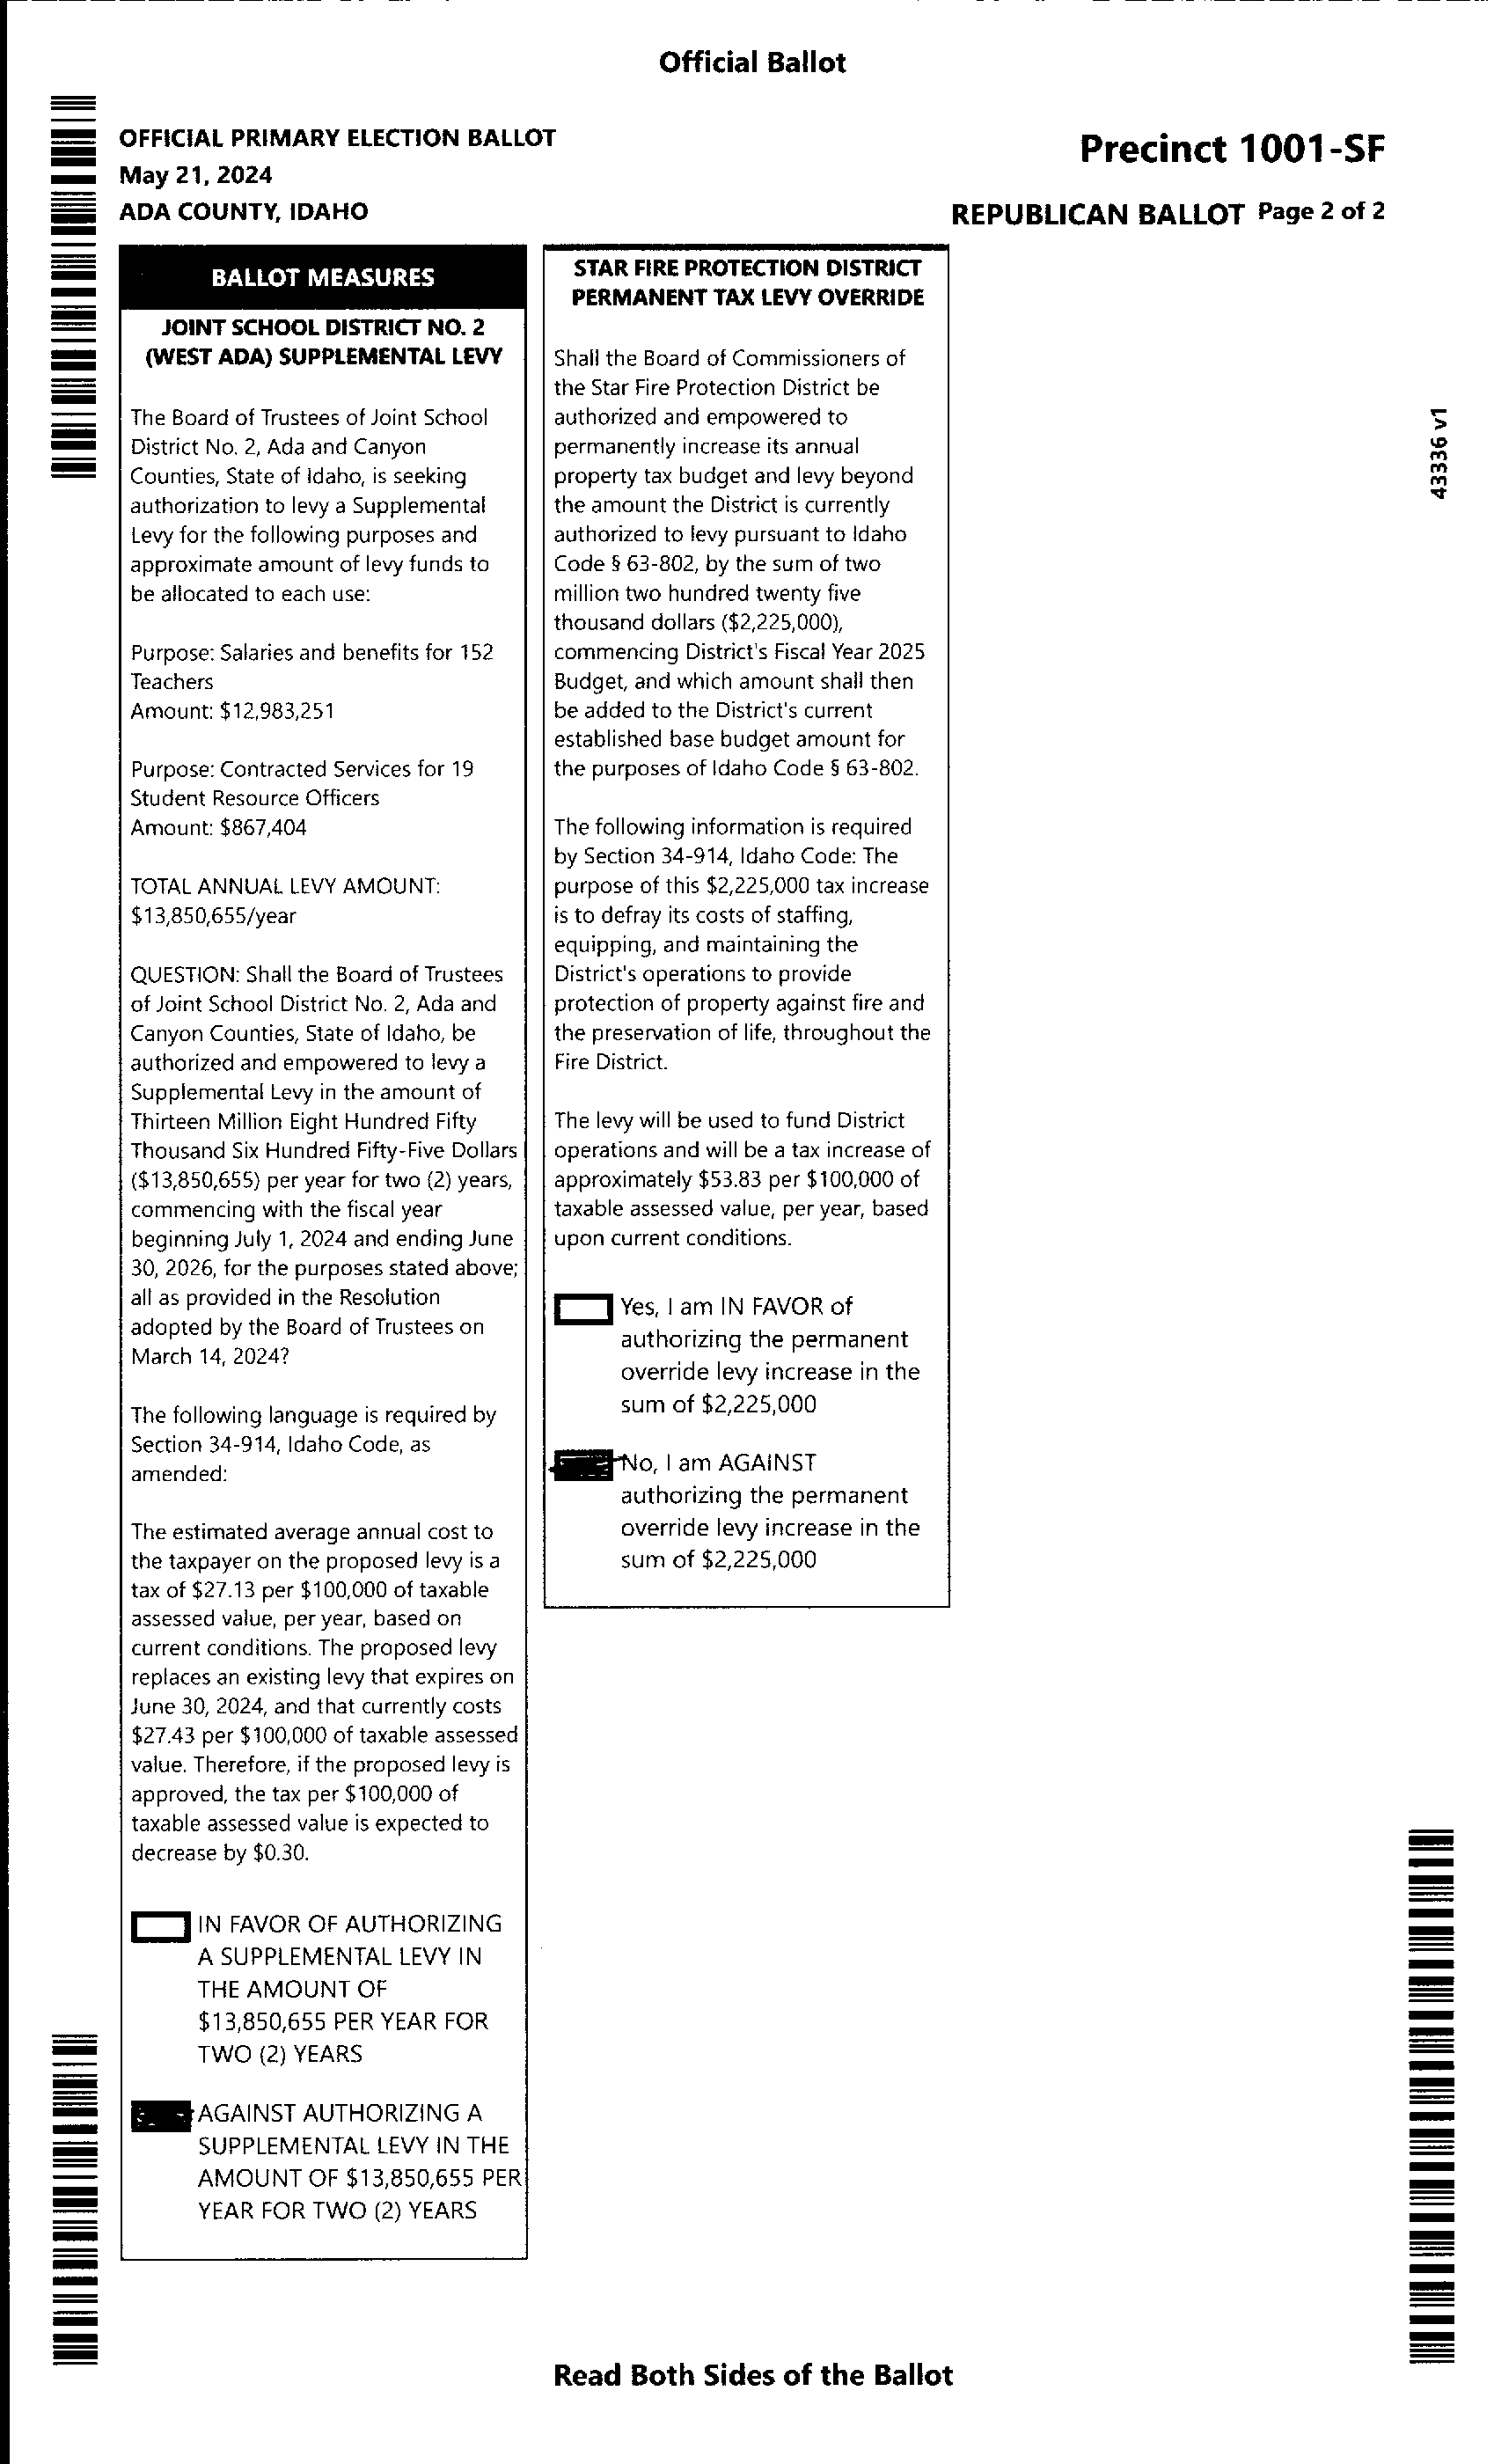

In [7]:
dataset[2]["images"][0]

In [8]:
dataset[2]["messages"]

[{'content': [{'text': '', 'type': 'text'}, {'text': None, 'type': 'image'}],
  'role': 'user'},
 {'content': [{'text': '{"metadata": {"File Name": "00A94578-34A2-4B51-AE32-70719834A418__Back.png", "Election Date": "May 21, 2024", "County": "ADA COUNTY", "State": "IDAHO", "Precinct": "1001-SF", "Ballot Title": "OFFICIAL PRIMARY ELECTION BALLOT", "Election Type": "PRIMARY", "Ballot Type": "REPUBLICAN", "Ballot Page": "2", "Ballot Pages": "2", "Writing on Ballot": {}, "LLM Provider": "Anthropic Claude", "Model Used": "claude-3-5-sonnet-latest"}, "BALLOT MEASURES": {"JOINT SCHOOL DISTRICT NO. 2 SUPPLEMENTAL LEVY": {"Options": {"AGAINST": true, "IN FAVOR": null}, "Status": "Valid"}, "STAR FIRE PROTECTION DISTRICT PERMANENT TAX LEVY OVERRIDE": {"Options": {"AGAINST": true, "IN FAVOR": null}, "Status": "Valid"}}}',
    'type': 'text'}],
  'role': 'assistant'}]

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

We use our new `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [9]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = dataset,
    args = SFTConfig(
        per_device_train_batch_size = 1, # Reduce to 1 to make Pixtral fit!
        gradient_accumulation_steps = 4, # CHarris - reduce from 4 to 2 to help memory error.
        warmup_steps = 5,
        max_steps = 30,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "paged_adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

In [10]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100-SXM4-40GB. Max memory = 39.564 GB.
8.66 GB of memory reserved.


In [11]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 217 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 4
\        /    Total batch size = 4 | Total steps = 30
 "-____-"     Number of trainable parameters = 18,677,760
🦥 Unsloth needs about 1-3 minutes to load everything - please wait!
Unsloth: Not an error, but LlavaForConditionalGeneration does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


Step,Training Loss
1,2.296900
2,2.498000
3,2.601600
4,2.619100
5,1.543000
6,1.882800
7,1.377000
8,1.775400
9,1.502000
10,1.417000


In [12]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

232.6244 seconds used for training.
3.88 minutes used for training.
Peak reserved memory = 13.881 GB.
Peak reserved memory for training = 5.221 GB.
Peak reserved memory % of max memory = 35.085 %.
Peak reserved memory for training % of max memory = 13.196 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

In [13]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[2]["images"][0]
instruction = ""

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 1000,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.


{"metadata": {"File Name": "46565654-434C-485B-853C-44455543__Back.png", "Election Date": "May 21, 2024", "County": "ADA COUNTY", "State": "IDAHO", "Precinct": "1001-SF", "Ballot Title": "OFFICIAL PRIMARY ELECTION BALLOT", "Election Type": "PRIMARY", "Ballot Type": "REPUBLICAN", "Ballot Page": "2", "Ballot Pages": "2", "Writing on Ballot": {}, "LLM Provider": "Anthropic", "Model Used": "claude-3-5-sonnet-latest"}, "BALLOT MEASURES": {"JOINT SCHOOL DISTRICT NO. 2 SUPPLEMENTAL LEVY": {"Options": {"AGAINST": true, "IN FAVOR": null}, "Status": "Valid"}, "STAR FIRE PROTECTION DISTRICT PERMANENT TAX LEVY OVERRIDE": {"Options": {"AGAINST": true, "IN FAVOR": null}, "Status": "Valid"}}}</s>


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [15]:
# model.save_pretrained("lora_model") # Local saving
# tokenizer.save_pretrained("lora_model")
model.push_to_hub("harriscj/pixtral_ballot_finetune", token = "...") # Online saving
tokenizer.push_to_hub("harriscj/pixtral_ballot_finetune", token = "...") # Online saving

['lora_model/processor_config.json']

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[2]["images"][0]
instruction = "What colors are in the image?"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 64,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

The image features the colors black, orange, white, and gray.</s>


### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [27]:
# Select ONLY 1 to save! (Both not needed!)

# Save locally to 16bit
# model.save_pretrained_merged("pixtral_ballot_finetune", tokenizer,)

# To export and save to your Hugging Face account
HF_TOKEN = userdata.get('HF_TOKEN')
model.push_to_hub_merged("harriscj/pixtral_ballot_finetune", tokenizer, token = HF_TOKEN)

  0%|          | 0/1 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

model-00001-of-00006.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00006.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00006.safetensors:   0%|          | 0.00/4.91G [00:00<?, ?B/s]

model-00004-of-00006.safetensors:   0%|          | 0.00/4.91G [00:00<?, ?B/s]

model-00005-of-00006.safetensors:   0%|          | 0.00/4.26G [00:00<?, ?B/s]

model-00006-of-00006.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit: 100%|██████████| 6/6 [05:04<00:00, 50.67s/it]


  0%|          | 0/6 [00:00<?, ?it/s]

model-00001-of-00006.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00006.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00006.safetensors:   0%|          | 0.00/4.91G [00:00<?, ?B/s]

model-00004-of-00006.safetensors:   0%|          | 0.00/4.91G [00:00<?, ?B/s]

model-00005-of-00006.safetensors:   0%|          | 0.00/4.26G [00:00<?, ?B/s]

model-00006-of-00006.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

*** IMPORTANT ***

Save the model to a GGUF file which can be used by Ollama

*ARGH! the following wants to restart the session!*

In [17]:
!pip install transformers>=4.31.0 optimum>=1.12.0
!pip install --upgrade optimum[exporters]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 107.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 91.3 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.0
    Uninstalling tokenizers-0.21.0:
      Successfully uninstalled tokenizers-0.21.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.1
    Uninstalling transformers-4.47.1:
      Successfully uninstalled transformers-4.47.1


In [18]:
# First save the model to the Google Colab environment

from transformers import AutoConfig, AutoTokenizer
from optimum.exporters.transformers import TransformersModelExporter
from optimum.utils import DEFAULT_DUMMY_SHAPES

model_id = "harriscj/pixtral_ballot_finetune" # Replace with your model ID
config = AutoConfig.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = FastVisionModel.from_pretrained_merged(model_id, config=config, tokenizer=tokenizer)

exporter = TransformersModelExporter(model=model, config=config, tokenizer=tokenizer)

exporter.export(
    export_format="ggml",
    export_path="pixtral_ballot_finetune.ggmlv3.q4_0.bin", # Replace with your desired path
    task="text-generation",
    input_shapes=DEFAULT_DUMMY_SHAPES,
    device="cuda", # Change to "cpu" if needed
    cache_dir=".cache",
)

ModuleNotFoundError: No module named 'optimum.exporters.transformers'

In [ ]:
# Now export the model to Huggingface

from huggingface_hub import upload_file

repo_id = "harriscj/pixtral_ballot_finetune"  # Replace with your repo ID
filename = "pixtral_ballot_finetune.ggmlv3.q4_0.bin"  # Replace with your GGUF filename
upload_file(
    path_or_fileobj=filename,
    path_in_repo=filename,
    repo_id=repo_id,
    token = userdata.get('HF_TOKEN'),
)

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/unsloth) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Llama 3.2 Conversational notebook. [Free Colab](https://colab.research.google.com/drive/1T5-zKWM_5OD21QHwXHiV9ixTRR7k3iB9?usp=sharing)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/drive/1WZDi7APtQ9VsvOrQSSC5DDtxq159j8iZ?usp=sharing)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/drive/1j0N4XTY1zXXy7mPAhOC1_gMYZ2F2EBlk?usp=sharing)
4. Qwen 2 VL Vision finetuning - Maths OCR to LaTeX. [Free Colab](https://colab.research.google.com/drive/1whHb54GNZMrNxIsi2wm2EY_-Pvo2QyKh?usp=sharing)
5. Pixtral 12B Vision finetuning - General QA datasets. [Free Colab](https://colab.research.google.com/drive/1K9ZrdwvZRE96qGkCq_e88FgV3MLnymQq?usp=sharing)
6. More notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [Github](https://github.com/unslothai/unsloth)!

<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>